In [1]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc

In [2]:
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def fast_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def fast_estimation(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))
    oof_list = []
    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
#         print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        
        oof_list.append(roc_auc_score(y.iloc[test_idx], oof[test_idx]))
        
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

#         print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
#     print('Training has finished.')
#     print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

#     feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


#     plt.figure(figsize=(16, 16))
#     sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
#     plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return roc_auc_score(y, oof)
def submission_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def outliers(i, df, col):
    scaled = StandardScaler().fit_transform(df[col].dropna()[:, np.newaxis])
    
    low_range = scaled[scaled[:,0].argsort()][:10]
    high_range= scaled[scaled[:,0].argsort()][-10:]
    if len(np.unique(low_range)) >= 2 or len(np.unique(high_range)) >= 2:
        print(i, col)
        print('outer range (low) of the distribution:')
        print(low_range)
        print('\nouter range (high) of the distribution:')
        print(high_range)
        print('\n')

        return col, (high_range[-1]/high_range[0])[0], (low_range[-1]/low_range[0])[0]
def kde_target(var_name, df):    
    corr = df['isFraud'].corr(df[var_name])
    avg_repaid = df.loc[df['isFraud'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['isFraud'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 9))
    
    sns.kdeplot(df.loc[df['isFraud'] == 0, var_name], label = 'isFraud == 0')
    sns.kdeplot(df.loc[df['isFraud'] == 1, var_name], label = 'isFraud == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    print('The correlation between %s and the isFraud is %0.4f' % (var_name, corr))
def check_outliers(flag, df, col):
    if flag == 'train':
        sns.distplot(df[col].dropna())
        kde_target(col, df)
    
    else:
        pass        
    return df[col].value_counts().sort_index()
def time_series_validation(X, y, params):
    folds = TimeSeriesSplit(n_splits=5)

    aucs = list()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)

        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
        aucs.append(clf.best_score['valid_1']['auc'])

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs))
    print('-' * 30)

In [5]:
main_path = r'../..'
data_path = main_path+'/data/'

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(main_path)
from BayDS import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
train_ = pd.read_csv(data_path +  'X_score_agg.csv').set_index('TransactionID')
test_ = pd.read_csv(data_path + 'test_aggs.csv').set_index('TransactionID')

In [14]:
train = pd.read_pickle(data_path + 'train_09457_with_additions.pkl')

test = pd.read_pickle(data_path + 'test_09457_with_additions.pkl')

# del train_, test_
# gc.collect()

NameError: name 'train_' is not defined

In [15]:
X = train.drop(['Date', 'isFraud'], axis=1)

In [38]:
train_.drop('score', axis=1, inplace=True)

In [39]:
X = pd.concat([train, train_], axis=1).drop('isFraud', axis=1)
del train, train_
gc.collect()

NameError: name 'train' is not defined

In [ ]:
testall = pd.concat([test, test_], axis=1)#.drop('isFraud', axis=1)

del test_
gc.collect()

testall.drop(3577539, inplace=True)

In [16]:
y = pd.read_pickle(data_path + 'y.pkl')

# X.drop(['Date', 'isFraud'], axis=1, inplace=True)

In [ ]:
testall.drop('Date', axis=1, inplace=True)
train.drop('Date', axis=1, inplace=True)
# test.drop('Date', axis=1, inplace=True)

In [ ]:
X = X.loc[:,~X.columns.duplicated()]
testall = testall.loc[:,~testall.columns.duplicated()]

In [19]:
del train
gc.collect()

5883

In [20]:
print(X.shape, test.shape)

(590540, 639) (506691, 639)


In [22]:
cols = "TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(",")
train_test = X[cols].append(test[cols])

In [23]:
for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    X[col+'_count'] = X[col].map(col_count)
    test[col+'_count'] = test[col].map(col_count)
#     print(col,test[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    X[col+'_amtcount'] = X[col].map(col_count)
    test[col+'_amtcount'] = test[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    X[col+'_C5count'] = X[col].map(col_count2) / (X[col].map(col_count1) + 0.01)
    test[col+'_C5count'] = test[col].map(col_count2) / (test[col].map(col_count1) + 0.01)
    
del train_test

In [24]:
col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = X[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)

V126 24875
V127 104743
V128 46447
V129 6555
V130 72061
V131 24989
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6335
V206 4711
V207 8867
V208 9699
V209 10061
V210 9836
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6651
V267 10219
V268 8347
V270 7868
V271 8110
V272 7959
V273 9401
V274 11959
V275 9821
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 14366
V310 99482
V311 8764
V312 40465
V313 43009
V314 50538
V315 44021
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113


In [28]:
# train_pos = train[train['isFraud']==1]
# train_neg = train[train['isFraud']==0]

# train_neg = train_neg.sample(int(train.shape[0] * 0.2), random_state=0)

# d = pd.concat([train_pos,train_neg]).sort_index()

# d.drop('isFraud', axis=1, inplace=True)

# del train_pos, train_neg
# gc.collect()

In [27]:
# print(d.shape, test.shape)

In [25]:
# train_pos = X[X['isFraud']==1]
# train_neg = X[X['isFraud']==0]

# train_neg = train_neg.sample(int(X.shape[0] * 0.2), random_state=0)

# dall = pd.concat([train_pos,train_neg]).sort_index()

# del train_pos, train_neg
# gc.collect()

In [26]:
# dall.replace(-999, np.nan, inplace=True)
# dall.replace(-9999, np.nan, inplace=True)
# dall.replace(-99999, np.nan, inplace=True)
# dall.replace(-999999, np.nan, inplace=True)
# dall.replace(-np.inf, np.nan, inplace=True)
# dall.replace(np.inf, np.nan, inplace=True)

Fold 1 started at Tue Sep 17 21:28:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[295]	training's auc: 0.999887	training's auc: 0.999887	valid_1's auc: 0.915302	valid_1's auc: 0.915302
Fold 2 started at Tue Sep 17 21:41:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[166]	training's auc: 0.998757	training's auc: 0.998757	valid_1's auc: 0.930304	valid_1's auc: 0.930304
Fold 3 started at Tue Sep 17 21:51:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[135]	training's auc: 0.998259	training's auc: 0.998259	valid_1's auc: 0.928464	valid_1's auc: 0.928464
Fold 4 started at Tue Sep 17 22:00:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[156]	training's auc: 0.998687	training's auc: 0.998687	valid_1's auc: 0.944659	valid_1's auc: 0.944659
Fold 5 started at Tu

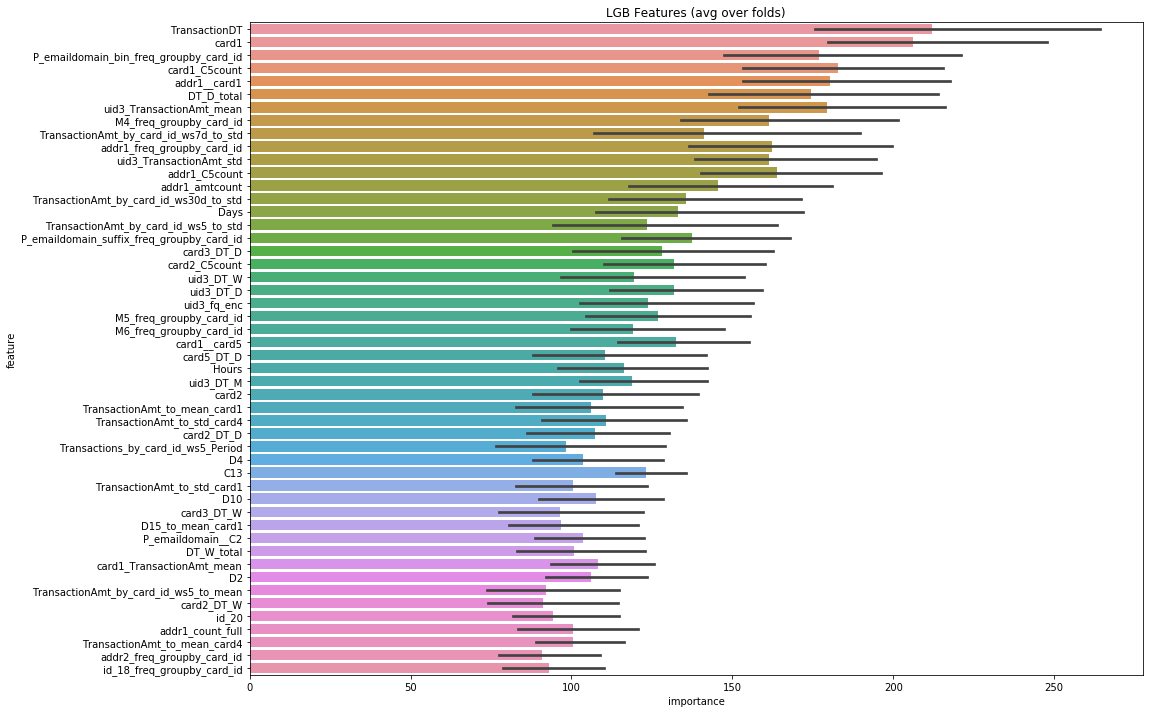

In [29]:
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'auc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 500,
          'min_child_weight': 3,
          'data_random_seed': 17,
         'nthreads':4}

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_dict_lgb = train_model_classification(X=X, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [30]:
pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index).to_csv('lgb_9469+new_feats_preds.csv')

In [29]:
params = {'num_leaves': 491,
          'min_child_weight': 3,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 20,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 1500,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}
result_dict_lgb_after_rfe2 = train_model_classification(X=d[[x for x in d.columns if x not in col_del]], 
                                                        X_test=test[[x for x in d.columns if x not in col_del]], 
                                                        y=y.loc[d.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [30]:
pd.DataFrame(result_dict_lgb_after_rfe2['prediction'], columns=['isFraud'], index=test.index).to_csv('lgb_downsample_9469+new_feats_+col_del_preds.csv')

NameError: name 'result_dict_lgb_after_rfe2' is not defined

In [31]:
params = {'num_leaves': 491,
          'min_child_weight': 30,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.9,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': 15,
          'learning_rate': 0.05,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 1500,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}
result_dict_lgb_after_rfe3 = train_model_classification(X=dall[[x for x in dall.columns if x not in 'TransactionDT']], 
                                                        X_test=testall[[x for x in dall.columns if x not in 'TransactionDT']], 
                                                        y=y.loc[dall.index], params=params, folds=folds,
                                                     model_type=train_options['model_type'], 
                                                     eval_metric=train_options['eval_metric'],
                                                     plot_feature_importance=True,
                                                     verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                     n_estimators=train_options['n_estimators'], 
                                                     averaging=train_options['averaging'],
                                                     n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [32]:
pd.DataFrame(result_dict_lgb_after_rfe3['prediction'], columns=['isFraud'], index=test.index).to_csv('lgb_downsample_9469+all_aggs+new_feats_+col_del_preds.csv')

NameError: name 'result_dict_lgb_after_rfe3' is not defined

In [31]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

In [33]:
sub1 = pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index)
# sub2 = pd.DataFrame(result_dict_lgb_after_rfe2['prediction'], columns=['isFraud'], index=test.index)
# sub3 = pd.DataFrame(result_dict_lgb_after_rfe3['prediction'], columns=['isFraud'], index=test.index)

In [34]:
sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

In [36]:
sample_submission.to_csv('ensemble_lgb_17_09_new_feats.csv')

In [38]:
sample_submission.to_csv('ensemble_lgb_17_09_05025.csv')

NameError: name 'sample_submission' is not defined

In [39]:
result_dict_lgb_after_rfe = train_model_classification(X=d.drop([x for x in d.columns if '_ws' in x], axis=1), X_test=test.drop([x for x in d.columns if '_ws' in x], axis=1), y=y.loc[d.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [40]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }
n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold }

result_dict_lgb_after_rfe = train_model_classification(X=dall[notvallcols], X_test=testall[notvallcols], y=y.loc[dall.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [41]:
set(dall.columns) & set(d.columns)

NameError: name 'dall' is not defined

In [42]:
set(dall.columns) - set(d.columns)

NameError: name 'dall' is not defined

In [43]:
add1 = ['TransactionAmt_by_card_id_ws100_to_mean',
 'TransactionAmt_by_card_id_ws100_to_std',
 'TransactionAmt_by_card_id_ws10_to_mean',
 'TransactionAmt_by_card_id_ws10_to_std',
 'TransactionAmt_by_card_id_ws1d_to_mean',
 'TransactionAmt_by_card_id_ws1d_to_std',
 'TransactionAmt_by_card_id_ws2d_to_mean',
 'TransactionAmt_by_card_id_ws2d_to_std',
 'TransactionAmt_by_card_id_ws3d_to_mean',
 'TransactionAmt_by_card_id_ws3d_to_std']

In [44]:
add2 = ['C1_by_card_id_ws100_to_mean',
 'C1_by_card_id_ws100_to_std',
 'C1_by_card_id_ws10_to_mean',
 'C1_by_card_id_ws10_to_std',
 'C1_by_card_id_ws1d_to_mean',
 'C1_by_card_id_ws1d_to_std',
 'C1_by_card_id_ws2d_to_mean',
 'C1_by_card_id_ws2d_to_std',
 'C1_by_card_id_ws30d_to_mean',
 'C1_by_card_id_ws30d_to_std',
 'C1_by_card_id_ws3d_to_mean',
 'C1_by_card_id_ws3d_to_std',
 'C1_by_card_id_ws5_to_mean',
 'C1_by_card_id_ws5_to_std',
 'C1_by_card_id_ws7d_to_mean',
 'C1_by_card_id_ws7d_to_std']

In [45]:
result_dict_lgb_after_rfe = train_model_classification(X=dall[list(initcols) + add1], 
                                                       
                                            X_test=testall[list(initcols) + add1], 
                                            y=y.loc[dall.index], 
                                                       
                                                       params=params, folds=folds,
                                                         model_type=train_options['model_type'], 
                                                         eval_metric=train_options['eval_metric'],
                                                         plot_feature_importance=True,
                                                         verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                         n_estimators=train_options['n_estimators'], 
                                                         averaging=train_options['averaging'],
                                                         n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [46]:
result_dict_lgb_after_rfe = train_model_classification(X=dall[list(initcols) + ['C1_by_card_id_ws30d_to_std']], 
                                                       
                                            X_test=testall[list(initcols) + ['C1_by_card_id_ws30d_to_std']], 
                                            y=y.loc[dall.index], 
                                                       
                                                       params=params, folds=folds,
                                                         model_type=train_options['model_type'], 
                                                         eval_metric=train_options['eval_metric'],
                                                         plot_feature_importance=True,
                                                         verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                                         n_estimators=train_options['n_estimators'], 
                                                         averaging=train_options['averaging'],
                                                         n_jobs=10, groups=None)

NameError: name 'train_model_classification' is not defined

In [47]:
pd.DataFrame(d.iloc[:, 500:550].columns)

NameError: name 'd' is not defined

In [48]:
[x for x in d.columns if '_ws' in x]

NameError: name 'd' is not defined

In [49]:
dall[list(initcols)]

NameError: name 'dall' is not defined

In [50]:
corr_add2 = dall[list(initcols) + add2].corr()

NameError: name 'dall' is not defined

In [51]:
corr_add2.loc[add2][corr_add2>0.95].dropna(how='all', axis=1)

NameError: name 'corr_add2' is not defined

In [52]:
df_num_corr = X.corr()

NameError: name 'X' is not defined

In [53]:
df_num_corr_09 = df_num_corr.where(df_num_corr>0.99).copy()

for i in df_num_corr.index:
    j = i
    df_num_corr_09.loc[i, j] = np.nan
    
df_num_corr_09 = df_num_corr_09.dropna(how='all', axis=0).copy()
df_num_corr_09.dropna(how='all', axis=1, inplace=True)

df_num_corrs = pd.DataFrame(columns = ['var1', 'var2', 'corr'])

for k, i in enumerate(df_num_corr_09.index):
    for j in df_num_corr_09.columns[k:]:
        if df_num_corr_09.loc[i, j] > 0:
            df_temp = pd.DataFrame(columns = ['var1', 'var2', 'corr'], data = [[i, j, df_num_corr_09.loc[i, j]]])
            df_num_corrs = df_num_corrs.append(df_temp, ignore_index=True)
            
df_num_corrs.sort_values(by='corr', inplace=True, ascending=False)

NameError: name 'df_num_corr' is not defined

In [54]:
df_num_corrs

NameError: name 'df_num_corrs' is not defined

In [55]:
X

NameError: name 'X' is not defined